# AI Security 2
## Homework 1: Adversarial Attack
### 2020330003 Changho Choi

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [13]:
epsilon = 25/255
alpha = 10/255
iters = 15
targets = []
datas = []
labels = []
pretrained_model = "./lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [14]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=False)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
# Get 1000 data, label, target pairs
cnt = 0
for i, (data, label) in enumerate(test_loader):
    if cnt == 1000:
        break

    target = torch.randint(0, 10, (1, )).item()
    while target == label:
        target = torch.randint(0, 10, (1, )).item()
    
    data, label = data.to(device), label.to(device)
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    
    if init_pred.item() != label.item():
        continue
    
    else:
        cnt += 1
        targets.append(target)
        datas.append(data)
        labels.append(label)

datas = torch.stack(datas)
labels = torch.stack(labels)
targets = torch.tensor(targets)

In [16]:
# FGSM attack code
def fgsm_attack(image, data_grad, epsilon):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# PGD attack code
def pgd_attack(origin, image, data_grad, epsilon, alpha):
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - alpha*sign_data_grad
    # Adding clipping to maintain [0,1] range
    
    perturbed_image = torch.clamp(perturbed_image, min=origin-epsilon, max=origin+epsilon)    
    clip = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return clip

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [17]:
def fgsm_test( model, device, test_loader, epsilon, targets, datas, labels ):

    # Accuracy counter
    correct = 0
    attack_success = 0
    adv_examples = []
    
    # Loop over all examples in test set
    for i in range(len(targets)):
        target = targets[i:i+1].to(device)
        data = datas[i]
        label = labels[i]
        # Send the data and label to the device
        data, label = data.to(device), label.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != label.item():
            print("Wrong Data")
            break

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, data_grad, epsilon)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            attack_success += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == label.item():
                correct += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    accuracy = correct/float(len(targets))
    success_rate = attack_success/float(len(targets)) * 100
    print("===FGSM ATTACK RESULT===")
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(targets)} = {accuracy}")
    print(f"\t\tAttack Success Rate(%) = ({attack_success} / {len(targets)}) * 100 = {success_rate:.2f}\n")
    
    # Return the accuracy and an adversarial example
    return accuracy, success_rate, adv_examples

In [18]:
def pgd_test( model, device, test_loader, datas, labels, targets, epsilon, alpha, iters ):

    # Accuracy counter
    correct = 0
    attack_success = 0
    adv_examples = []

    # Loop over all examples in test set
    for i in range(len(targets)):
        # Send the target, data, origin and label to the device
        target = targets[i:i+1].to(device)
        data = datas[i].to(device)
        origin = denorm(datas[i].to(device))
        label = labels[i].to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != label.item():
            print("Wrong Data")
            break
        
        for _ in range(iters):
            
            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect ``datagrad``
            data_grad = data.grad.data

            # Restore the data to its original scale
            data_denorm = denorm(data)
            
            # Call PGD Attack
            perturbed_data = pgd_attack(origin, data_denorm, data_grad, epsilon, alpha)

            # # Reapply normalization
            # perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

            # # Re-classify the perturbed image
            # output = model(perturbed_data_normalized)
             # Reapply normalization
            data = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

            # Set requires_grad attribute of tensor. Important for Attack
            data = data.to(device).clone().detach().requires_grad_(True)

            # Re-classify the perturbed image
            output = model(data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            attack_success += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == label.item():
                correct += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    accuracy = correct/float(len(targets))
    success_rate = attack_success/float(len(targets)) * 100
    print("===PGD ATTACK RESULT===")
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(targets)} = {accuracy}")
    print(f"\t\tAttack Success Rate(%) = ({attack_success} / {len(targets)}) * 100 = {success_rate:.2f}\n")
    
    # Return the accuracy and an adversarial example
    return accuracy, success_rate, adv_examples

In [19]:
examples = []

# Run test for each epsilon
fgsm_acc, fgsm_rate, fgsm_ex = fgsm_test(model, device, test_loader, epsilon, targets, datas, labels)
pgd_acc, pgd_rate, pgd_ex = pgd_test(model, device, test_loader, datas, labels, targets, epsilon, alpha, iters)
examples.append(fgsm_ex)
examples.append(pgd_ex)

===FGSM ATTACK RESULT===
Epsilon: 0.10	Test Accuracy = 937 / 1000 = 0.937
		Attack Success Rate(%) = (24 / 1000) * 100 = 2.40

===PGD ATTACK RESULT===
Epsilon: 0.10	Test Accuracy = 879 / 1000 = 0.879
		Attack Success Rate(%) = (104 / 1000) * 100 = 10.40



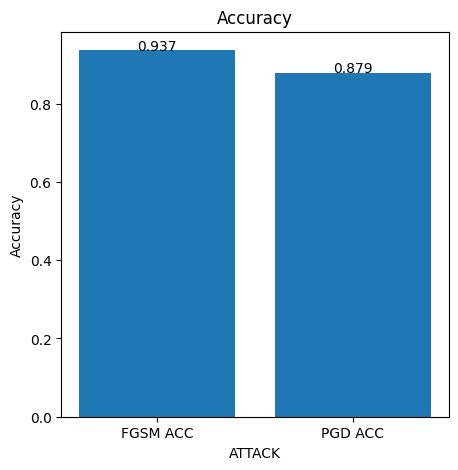

In [20]:
plt.figure(figsize=(5,5))
acc = [fgsm_acc, pgd_acc]
acc_label = ['FGSM ACC', 'PGD ACC']

plt.bar(acc_label, acc)
plt.title("Accuracy")
plt.xlabel("ATTACK")
plt.ylabel("Accuracy")
plt.text('FGSM ACC', fgsm_acc, fgsm_acc, horizontalalignment='center')
plt.text('PGD ACC', pgd_acc, pgd_acc, horizontalalignment='center')
plt.show()

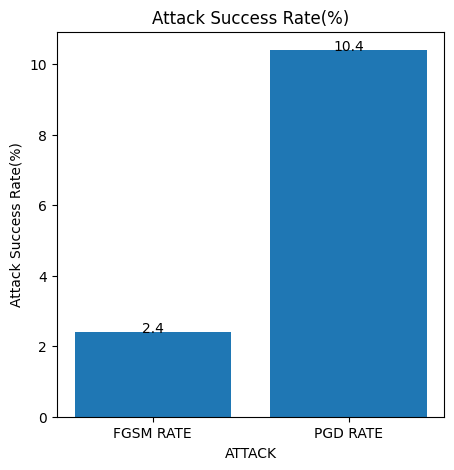

In [21]:
plt.figure(figsize=(5,5))
rate = [fgsm_rate, pgd_rate]
success_label = ['FGSM RATE', 'PGD RATE']

plt.bar(success_label, rate)
plt.title("Attack Success Rate(%)")
plt.xlabel("ATTACK")
plt.ylabel("Attack Success Rate(%)")
plt.text('FGSM RATE', fgsm_rate, fgsm_rate, horizontalalignment='center')
plt.text('PGD RATE', pgd_rate, pgd_rate, horizontalalignment='center')
plt.show()

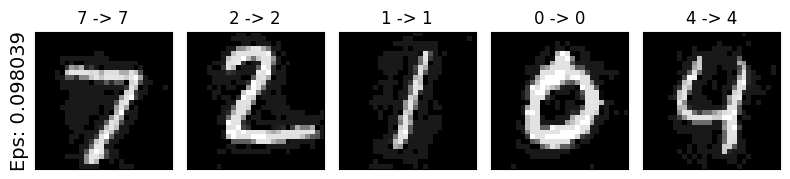

In [22]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(1,len(examples[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel(f"Eps: {epsilon:2f}", fontsize=14)
    orig,adv,ex = examples[0][j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [23]:
def pgd_advanced_test( model, device, test_loader, datas, labels, targets, epsilon, alpha, iters ):

    # Accuracy counter
    correct = 0
    attack_success = 0
    adv_examples = []
    alpha_org = alpha
    # Loop over all examples in test set
    for i in range(len(targets)):
        # Send the target, data, origin and label to the device
        target = targets[i:i+1].to(device)
        data = datas[i].to(device)
        origin = denorm(datas[i].to(device))
        label = labels[i].to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != label.item():
            print("Wrong Data")
            break
        
        alpha = alpha_org
        
        for _ in range(iters):
            alpha -= 1/510
            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect ``datagrad``
            data_grad = data.grad.data

            # Restore the data to its original scale
            data_denorm = denorm(data)
            
            # Call PGD Attack
            perturbed_data = pgd_attack(origin, data_denorm, data_grad, epsilon, alpha)

            # # Reapply normalization
            # perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

            # # Re-classify the perturbed image
            # output = model(perturbed_data_normalized)
             # Reapply normalization
            data = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

            # Set requires_grad attribute of tensor. Important for Attack
            data = data.to(device).clone().detach().requires_grad_(True)

            # Re-classify the perturbed image
            output = model(data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            attack_success += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == label.item():
                correct += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    accuracy = correct/float(len(targets))
    success_rate = attack_success/float(len(targets)) * 100
    print("===PGD ATTACK RESULT===")
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(targets)} = {accuracy}")
    print(f"\t\tAttack Success Rate(%) = ({attack_success} / {len(targets)}) * 100 = {success_rate:.2f}\n")
    
    # Return the accuracy and an adversarial example
    return accuracy, success_rate, adv_examples

In [24]:
examples = []
alpha = 15/255
# Run test for each epsilon

pgd_acc, pgd_rate, pgd_ex = pgd_test(model, device, test_loader, datas, labels, targets, epsilon, alpha, iters-5)
pgd_acc, pgd_rate, pgd_ex = pgd_advanced_test(model, device, test_loader, datas, labels, targets, epsilon, alpha, iters-5)

===PGD ATTACK RESULT===
Epsilon: 0.10	Test Accuracy = 906 / 1000 = 0.906
		Attack Success Rate(%) = (79 / 1000) * 100 = 7.90

===PGD ATTACK RESULT===
Epsilon: 0.10	Test Accuracy = 883 / 1000 = 0.883
		Attack Success Rate(%) = (100 / 1000) * 100 = 10.00



I've tried to set a large epsilon at first, and then decrease it during the iterations. The performance increases compared to the original PGD attack. However, it is not clear whether it is due to the changing method, or it's just a conclusion of large epsilon.

More advanced, what happend if increasing the epsilon during the iterations until the perturbed < epsilon, and after it reaches the epsilon, decrease the value of epsilon drastically? I did not check it because of my time limit, I think it has some funny points.